In [1]:
from IterativeBase import *
import numpy as np 
import pandas as pd 
import math 
import scipy as sp
import sympy as smp
import yfinance as yf

In [ ]:

from scipy.stats import norm

def black_scholes_call(S, K, sigma, r, t):
    d1 = (np.log(S/K) + (r + ((sigma**2)/2))*t) / (sigma * np.sqrt(t))
    d2 = d1 - (sigma * np.sqrt(t))
    C = S * norm.cdf(d1) - K * np.exp(-r*t) * norm.cdf(d2)
    return C

black_scholes_call(57758, 57800, 0.15, .05, 15/252)




np.float64(908.7347379361308)

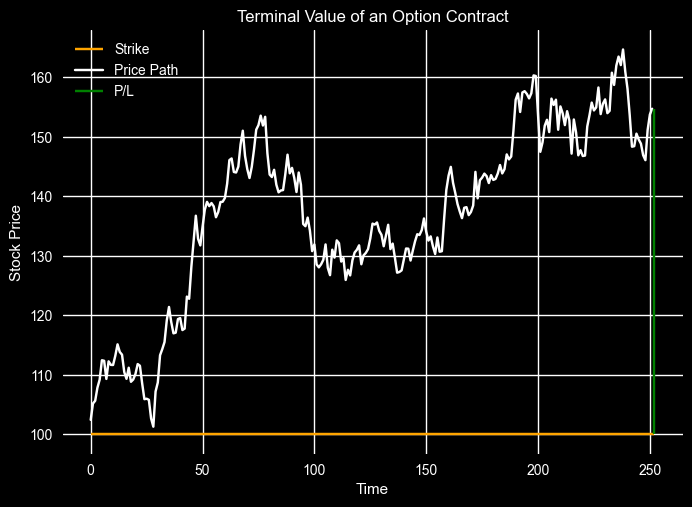

Premium at t=0: 14.231254785985819
P/L: 40.51579723943575


In [82]:
import matplotlib.pyplot as plt
import qfin as qf

# simulate dynamics of the underlying according to Geometric Brownian Motion
path = qf.simulations.GeometricBrownianMotion(100, 0.05, .3, 1/252, 1)


# create a chart of the price path and the strike price
plt.title("Terminal Value of an Option Contract")
plt.hlines(100, 0, 252, label='Strike', color='orange')
plt.plot(path.simulated_path, label='Price Path', color='white')
if max(path.simulated_path[-1] - 100, 0) == 0:
    plt.vlines(252, path.simulated_path[-1], 100, color='red', label="P/L")
else:
    plt.vlines(252, 100, path.simulated_path[-1], color='green', label="P/L")
plt.style.use('dark_background')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# print the premium and the resulting P/L
print("Premium at t=0:", black_scholes_call(100, 100, .3, .05, 1))
print("P/L:", max(path.simulated_path[-1] - 100, 0) - black_scholes_call(100, 100, .3, .05, 1))

In [83]:
print("Call Price:", black_scholes_call(100, 100, .3, .05, 1))
print("Market Maker Quote:", "13.43 @ 14.10")
print("Trade Edge:", black_scholes_call(100, 100, .3, .05, 1) - 14.10)

Call Price: 14.231254785985819
Market Maker Quote: 13.43 @ 14.10
Trade Edge: 0.13125478598581886


In [84]:
premium = 14.10 * 100
pls = []

for i in range(100000):
    path = qf.simulations.GeometricBrownianMotion(100, 0.05, .3, 1/252, 1)
    pls.append(max(path.simulated_path[-1] - 100, 0)*100 - premium)

np.mean(pls)

np.float64(79.72558397154378)

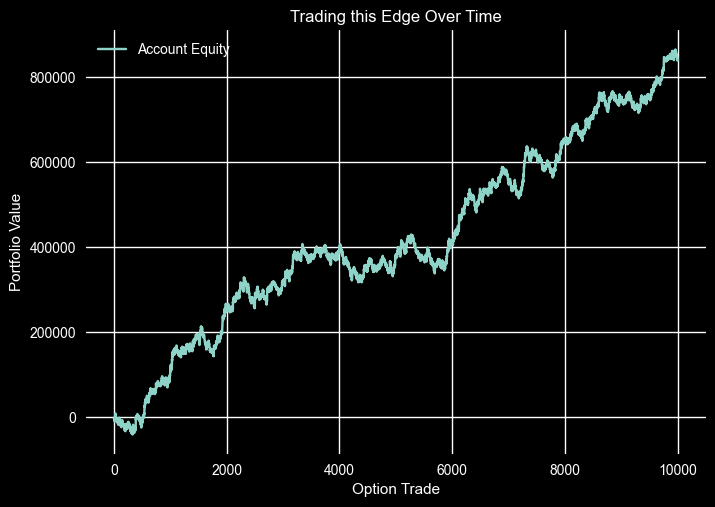

In [103]:
premium = 14.10 * 100
pls = []

for i in range(10000):
    path = qf.simulations.GeometricBrownianMotion(100, 0.05, .3, 1/252, 1)
    pls.append(max(path.simulated_path[-1] - 100, 0)*100 - premium)

plt.title("Trading this Edge Over Time")
plt.plot(np.cumsum(pls), label="Account Equity")
plt.style.use('dark_background')
plt.xlabel('Option Trade')
plt.ylabel('Portfolio Value')
plt.legend()
plt.show()

In [ ]:
# As we saw, this works only in the long-term. Mathmatically, it will approcach positive return over the long run, but you may lose severly in the short term. It makes assumptions, and it must. 

In [129]:
# The mistake I made was trying to build a castle with building the rooms in in it. GO step by step. Now, that I have the core, the logic, we can build it with real data. 
from scipy.stats import norm
import numpy as np

raw = pd.read_csv("aapl_2021_2023.csv")
raw.columns = raw.columns.str.strip()  # Remove leading/trailing spaces
# print(raw.columns.tolist())
raw.columns = raw.columns.str.strip()
raw = raw[['[UNDERLYING_LAST]', '[C_LAST]']]
raw = raw.loc[0:10000]
print(raw)

def black_scholes_call(S, K, sigma, r, t):
    d1 = (np.log(S/K) + (r + ((sigma**2)/2))*t) / (sigma * np.sqrt(t))
    d2 = d1 - (sigma * np.sqrt(t))
    C = S * norm.cdf(d1) - K * np.exp(-r*t) * norm.cdf(d2)
    return C




C:\Users\mihir\AppData\Local\Temp\ipykernel_8112\2839696613.py:5: DtypeWarning: Columns (15,17,18,20,21,23) have mixed types. Specify dtype option on import or set low_memory=False.
  raw = pd.read_csv("aapl_2021_2023.csv")


       [UNDERLYING_LAST]    [C_LAST]
0                 138.90    0.000000
1                 138.90    0.000000
2                 138.90    0.000000
3                 138.90   53.160000
4                 138.90   47.300000
...                  ...         ...
9996              147.05    1.150000
9997              147.05    0.730000
9998              147.05    0.420000
9999              147.05    0.260000
10000             147.05    0.170000

[10001 rows x 2 columns]


In [130]:
import pandas as pd
import numpy as np
from scipy.stats import norm

# Load and prepare raw data
raw = pd.read_csv("aapl_2021_2023.csv")
raw.columns = raw.columns.str.strip()  # remove leading/trailing spaces
raw = raw[['[UNDERLYING_LAST]', '[C_LAST]']]
raw = raw.loc[0:10000]

# Ensure numeric types
raw['[UNDERLYING_LAST]'] = pd.to_numeric(raw['[UNDERLYING_LAST]'], errors='coerce')
raw['[C_LAST]'] = pd.to_numeric(raw['[C_LAST]'], errors='coerce')

# Filter rows with meaningful price and underlying change
raw_filtered = raw[(raw['[C_LAST]'] > 0.1)]
raw_filtered = raw_filtered.reset_index(drop=True)

# Black–Scholes function (vectorized)
def black_scholes_call_vectorized(S, K, sigma, r, t):
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * t) / (sigma * np.sqrt(t))
    d2 = d1 - sigma * np.sqrt(t)
    C = S * norm.cdf(d1) - K * np.exp(-r*t) * norm.cdf(d2)
    return C

# Example constants
K = 150       # Strike
sigma = 0.3   # Implied vol
r = 0.05      # Risk-free rate
t = 30/252    # 30 trading days in years

# Compute theoretical prices
raw_filtered['theo_price'] = black_scholes_call_vectorized(
    raw_filtered['[UNDERLYING_LAST]'], K, sigma, r, t
)

# Optional: difference between market and theoretical
raw_filtered['price_diff'] = raw_filtered['theo_price'] - raw_filtered['[C_LAST]']

# Trade signal: 

# Define a threshold for actionable difference
threshold = 0.1  # adjust as needed

# Add trade signal column using lambda
raw_filtered['trade_signal'] = raw_filtered.apply(
    lambda row: 'BUY' if row['theo_price'] - row['[C_LAST]'] > threshold 
                else ('SELL' if row['[C_LAST]'] - row['theo_price'] > threshold else 'HOLD'),
    axis=1
)

print(raw_filtered[['[UNDERLYING_LAST]', '[C_LAST]', 'theo_price', 'price_diff', 'trade_signal']].head())


C:\Users\mihir\AppData\Local\Temp\ipykernel_8112\1250837386.py:6: DtypeWarning: Columns (15,17,18,20,21,23) have mixed types. Specify dtype option on import or set low_memory=False.
  raw = pd.read_csv("aapl_2021_2023.csv")


   [UNDERLYING_LAST]  [C_LAST]  theo_price  price_diff trade_signal
0              138.9     53.16    2.180495  -50.979505         SELL
1              138.9     47.30    2.180495  -45.119505         SELL
2              138.9     38.74    2.180495  -36.559505         SELL
3              138.9     36.40    2.180495  -34.219505         SELL
4              138.9     32.05    2.180495  -29.869505         SELL


In [135]:
import pandas as pd
import numpy as np
from scipy.stats import norm

class BlackScholesTrader(IterativeBase):
    def __init__(self, csv_file, strike, sigma, r, t, threshold=0.1):
        """
        csv_file : path to CSV containing '[UNDERLYING_LAST]' and '[C_LAST]'
        strike : strike price (K)
        sigma : implied volatility (annualized)
        r : risk-free rate
        t : time to expiration in years
        threshold : price difference threshold to trigger trade signals
        """
        self.csv_file = csv_file
        self.K = strike
        self.sigma = sigma
        self.r = r
        self.t = t
        self.threshold = threshold
        
        # Load and preprocess CSV
        self.load_data()
    
    def load_data(self):
        raw = pd.read_csv(self.csv_file)
        raw.columns = raw.columns.str.strip()
        raw = raw[['[UNDERLYING_LAST]', '[C_LAST]']]
        raw = raw.loc[0:10000]
        
        # Ensure numeric
        raw['[UNDERLYING_LAST]'] = pd.to_numeric(raw['[UNDERLYING_LAST]'], errors='coerce')
        raw['[C_LAST]'] = pd.to_numeric(raw['[C_LAST]'], errors='coerce')
        
        # Filter non-zero option prices
        self.data = raw[raw['[C_LAST]'] > 0.1].reset_index(drop=True)
    
    def compute_theoretical_prices(self):
        S = self.data['[UNDERLYING_LAST]']
        K, sigma, r, t = self.K, self.sigma, self.r, self.t
        
        d1 = (np.log(S/K) + (r + 0.5*sigma**2)*t) / (sigma * np.sqrt(t))
        d2 = d1 - sigma * np.sqrt(t)
        self.data['theo_price'] = S * norm.cdf(d1) - K * np.exp(-r*t) * norm.cdf(d2)
        
        # Price difference
        self.data['price_diff'] = self.data['theo_price'] - self.data['[C_LAST]']
    
    def generate_trade_signals(self):
        # Vectorized trade signal using lambda
        self.data['trade_signal'] = self.data.apply(
            lambda row: '1' if row['price_diff'] > self.threshold 
                        else ('-1' if row['price_diff'] < -self.threshold else '0'),
            axis=1
        )
    
    def run(self):
        self.compute_theoretical_prices()
        self.generate_trade_signals()
        return self.data[['[UNDERLYING_LAST]', '[C_LAST]', 'theo_price', 'price_diff', 'trade_signal']]


In [136]:
trader = BlackScholesTrader(
    csv_file="aapl_2021_2023.csv",
    strike=150,
    sigma=0.3,
    r=0.05,
    t=30/252,
    threshold=0.1
)

df_signals = trader.run()
print(df_signals.head())

C:\Users\mihir\AppData\Local\Temp\ipykernel_8112\2049223072.py:26: DtypeWarning: Columns (15,17,18,20,21,23) have mixed types. Specify dtype option on import or set low_memory=False.
  raw = pd.read_csv(self.csv_file)


   [UNDERLYING_LAST]  [C_LAST]  theo_price  price_diff trade_signal
0              138.9     53.16    2.180495  -50.979505           -1
1              138.9     47.30    2.180495  -45.119505           -1
2              138.9     38.74    2.180495  -36.559505           -1
3              138.9     36.40    2.180495  -34.219505           -1
4              138.9     32.05    2.180495  -29.869505           -1


In [146]:
class BlackScholesTraderExec(BlackScholesTrader):
    def __init__(self, csv_file, strike, sigma, r, t, threshold=0.1, amount=10000, use_spread=True):
        # Initialize base trading balance etc. via IterativeBase
        super().__init__(csv_file, strike, sigma, r, t, threshold)
        self.initial_balance = amount
        self.current_balance = amount
        self.units = 0
        self.trades = 0
        self.position = 0
        self.use_spread = use_spread

    def get_values(self, bar):
        """Override IterativeBase.get_values for CSV option data."""
        # Instead of a datetime, just use a string
        date = f"Row {bar}"
        # Use C_LAST as the "price" that buy/sell will operate on
        price = float(self.data['[C_LAST]'].iloc[bar])
        # Spread can be zero for options
        spread = 0.0
        return date, price, spread

    def execute_trades(self, unit_size=1):
        """
        Iterates through the dataset and executes trades based on trade_signal.
        unit_size: number of contracts to buy/sell per signal
        """
        for idx, row in self.data.iterrows():
            S = row['[UNDERLYING_LAST]']
            signal = row['trade_signal']

            if signal == '1':
                # Buy option (use market price)
                self.buy_instrument(bar=idx, units=unit_size, amount=None)
            elif signal == '-1':
                # Sell option (use market price)
                self.sell_instrument(bar=idx, units=unit_size, amount=None)
            # HOLD -> do nothing


In [147]:
trader_exec = BlackScholesTraderExec(
    csv_file="aapl_2021_2023.csv",
    strike=150,
    sigma=0.3,
    r=0.05,
    t=30/252,
    threshold=0.1,
    amount=10000
)

# Compute prices and trade signals
df_signals = trader_exec.run()
print(df_signals.head())

# Execute trades based on signals
trader_exec.execute_trades(unit_size=1)

# Check final balance and NAV
trader_exec.print_current_nav(bar=len(trader_exec.data)-1)
trader_exec.close_pos(bar=len(trader_exec.data)-1)


C:\Users\mihir\AppData\Local\Temp\ipykernel_8112\2049223072.py:26: DtypeWarning: Columns (15,17,18,20,21,23) have mixed types. Specify dtype option on import or set low_memory=False.
  raw = pd.read_csv(self.csv_file)


   [UNDERLYING_LAST]  [C_LAST]  theo_price  price_diff trade_signal
0              138.9     53.16    2.180495  -50.979505           -1
1              138.9     47.30    2.180495  -45.119505           -1
2              138.9     38.74    2.180495  -36.559505           -1
3              138.9     36.40    2.180495  -34.219505           -1
4              138.9     32.05    2.180495  -29.869505           -1
Row 0 | Selling 1 units for 53.16000
Row 1 | Selling 1 units for 47.30000
Row 2 | Selling 1 units for 38.74000
Row 3 | Selling 1 units for 36.40000
Row 4 | Selling 1 units for 32.05000
Row 5 | Selling 1 units for 30.67000
Row 6 | Selling 1 units for 25.15000
Row 7 | Selling 1 units for 23.30000
Row 8 | Selling 1 units for 22.20000
Row 9 | Selling 1 units for 23.85000
Row 10 | Selling 1 units for 18.00000
Row 11 | Selling 1 units for 17.31000
Row 12 | Selling 1 units for 15.60000
Row 13 | Selling 1 units for 17.15000
Row 14 | Selling 1 units for 12.90000
Row 15 | Selling 1 units for 13.

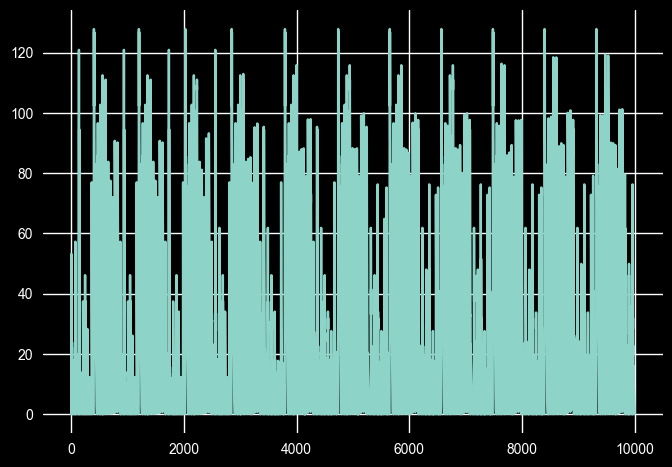

In [140]:
plt.plot(raw["[C_LAST]"])